# Ukrainian telegram messages research
#### Vynokury

---

## Installing requirements

This notebook requires theese modules to be installed:
- pandas
- matplotlb

In [2]:
%pip install pandas matplotlib nltk pymorphy3 pymorphy3-dicts-uk wordcloud


Note: you may need to restart the kernel to use updated packages.


## Initializing

In this part we initialize required modules, read dataset and clean it (analyzing it dirtiness).

### Import modules

In [3]:
import datetime as dt
import re
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import pymorphy3
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud


### Read dataset

Dataset is placed in the `message-weather.csv` file in a csv format.

In [4]:
dataset = pd.read_csv("message-weather.csv")
dataset

,city,date_weather,latitude_decimal,longitude_decimal,max_temperature,min_temperature,region_x,temperature,wind_direction,wind_speed,weather_description,date_hour_x,tg_message
0,Суми,2022-12-02 12:32,50.911944,34.803333,-0.2,-3.3,Сумська,-0.2,343,31.2,Overcast,2022-12-02 12:00:00,💥 Хотінь (Сумська обл.)\nЗагроза артилерійсько...
1,Марганець,2022-12-02 11:33,47.644722,34.604167,2.7,-0.1,Дніпропетровська,2.7,3,28.5,Overcast,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
2,Дніпро,2022-12-02 11:33,48.466111,35.025278,1.7,-1.6,Дніпропетровська,1.7,357,29.9,Partly cloudy,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
3,Нікополь,2022-12-02 11:33,47.577222,34.357500,2.4,0.1,Дніпропетровська,2.4,7,25.4,Overcast,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
4,Дніпро,2022-12-02 11:33,48.466111,35.025278,1.7,-1.6,Дніпропетровська,1.7,357,29.9,Partly cloudy,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8798,Херсон,2023-04-01 09:06,46.640000,32.614444,18.1,10.2,Херсонська,16.9,248,45.4,Mainly clear,2023-04-01 09:00:00,Херсонська область. Інформація щодо ворожих об...
8799,Херсон,2023-03-30 16:20,46.640000,32.614444,16.2,3.1,Херсонська,10.7,245,27.7,Mainly clear,2023-03-30 16:00:00,​​⚡️Отримав осколкове поранення під час бомбар...
8800,Херсон,2023-03-10 08:43,46.640000,32.614444,-1.5,-6.3,Херсонська,-2.7,65,36.1,Overcast,2023-03-10 08:00:00,Херсонська область. Інформація щодо ворожих об...
8801,Херсон,2023-03-10 08:43,46.640000,32.614444,-1.5,-6.3,Херсонська,-2.7,65,36.1,Overcast,2023-03-10 08:00:00,Херсонська область. Інформація щодо ворожих об...


### Clean columns

First of all, we rename columns `tg_message` to `message_text`, `latitude_decimal` to `latitude`, `longitude_decimal` to `longitude` and `region_x` to `region` for names to be understandable and easy-to-use.

In [5]:
dataset = dataset.rename(
    columns={
        "tg_message": "message_text",
        "latitude_decimal": "latitude",
        "longitude_decimal": "longitude",
        "region_x": "region",
    }
)

There is also a problem with parsing `date_weather` and `date_hour_x`, since those are strings, but have to be dates, so we convert them:

In [6]:
dataset.date_weather = pd.to_datetime(dataset.date_weather, format="%Y-%m-%d %H:%M")
dataset.date_hour_x = pd.to_datetime(dataset.date_hour_x, format="%Y-%m-%d %H:%M:%S")

Now the dataset looks like this:

In [7]:
dataset

,city,date_weather,latitude,longitude,max_temperature,min_temperature,region,temperature,wind_direction,wind_speed,weather_description,date_hour_x,message_text
0,Суми,2022-12-02 12:32:00,50.911944,34.803333,-0.2,-3.3,Сумська,-0.2,343,31.2,Overcast,2022-12-02 12:00:00,💥 Хотінь (Сумська обл.)\nЗагроза артилерійсько...
1,Марганець,2022-12-02 11:33:00,47.644722,34.604167,2.7,-0.1,Дніпропетровська,2.7,3,28.5,Overcast,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
2,Дніпро,2022-12-02 11:33:00,48.466111,35.025278,1.7,-1.6,Дніпропетровська,1.7,357,29.9,Partly cloudy,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
3,Нікополь,2022-12-02 11:33:00,47.577222,34.357500,2.4,0.1,Дніпропетровська,2.4,7,25.4,Overcast,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
4,Дніпро,2022-12-02 11:33:00,48.466111,35.025278,1.7,-1.6,Дніпропетровська,1.7,357,29.9,Partly cloudy,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8798,Херсон,2023-04-01 09:06:00,46.640000,32.614444,18.1,10.2,Херсонська,16.9,248,45.4,Mainly clear,2023-04-01 09:00:00,Херсонська область. Інформація щодо ворожих об...
8799,Херсон,2023-03-30 16:20:00,46.640000,32.614444,16.2,3.1,Херсонська,10.7,245,27.7,Mainly clear,2023-03-30 16:00:00,​​⚡️Отримав осколкове поранення під час бомбар...
8800,Херсон,2023-03-10 08:43:00,46.640000,32.614444,-1.5,-6.3,Херсонська,-2.7,65,36.1,Overcast,2023-03-10 08:00:00,Херсонська область. Інформація щодо ворожих об...
8801,Херсон,2023-03-10 08:43:00,46.640000,32.614444,-1.5,-6.3,Херсонська,-2.7,65,36.1,Overcast,2023-03-10 08:00:00,Херсонська область. Інформація щодо ворожих об...


## Examination

For further cleanup, it would be great to examine data.

### Dates

We can see that the `date_weather` is precise date (minute precision), but in comparison `date_hour_x` is not (hour precision). It would be great to examine their relation in the dataset:

In [8]:
(dataset["date_weather"] - dataset["date_hour_x"]).describe()

count                         8803
mean     0 days 00:30:25.239123026
std      0 days 00:17:11.615431718
min                0 days 00:00:00
25%                0 days 00:15:00
50%                0 days 00:32:00
75%                0 days 00:45:00
max                0 days 00:59:00
dtype: object

Since the `date_weather` stands between `date_hour_x` and `date_hour_x + 1h` (if we look at the maximum value of the difference) we can suppose, that `date_hour_x` actually equals `date_weather` without minutes component. So let's check this:

In [9]:
(dataset["date_weather"].dt.floor("h") == dataset["date_hour_x"]).describe()

count     8803
unique       1
top       True
freq      8803
dtype: object

We can see that there is only 1 unique element (True), that means, that this equality is true for all records in the dataset.

Because of this, we can say, that there is an error in the data: weather information is usually measured every hour in 0 minutes, but messages are usually sent in different time, so probably `date_hour_x` must be a time when weather was measured and `date_weather` a time when message was sent. This would explain why `date_hour_x` equals `date_weather` without minutes component: when data was collected, recent weather information was used.

To not get confused later, we rename `date_hour_x` to `weather_time` and `date_weather` to `message_time`.

In [10]:
dataset = dataset.rename(
    columns={
        "date_hour_x": "weather_time",
        "date_weather": "message_time",
    }
)

In final, we have normalized columns names and got this kind of table:

In [11]:
dataset

,city,message_time,latitude,longitude,max_temperature,min_temperature,region,temperature,wind_direction,wind_speed,weather_description,weather_time,message_text
0,Суми,2022-12-02 12:32:00,50.911944,34.803333,-0.2,-3.3,Сумська,-0.2,343,31.2,Overcast,2022-12-02 12:00:00,💥 Хотінь (Сумська обл.)\nЗагроза артилерійсько...
1,Марганець,2022-12-02 11:33:00,47.644722,34.604167,2.7,-0.1,Дніпропетровська,2.7,3,28.5,Overcast,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
2,Дніпро,2022-12-02 11:33:00,48.466111,35.025278,1.7,-1.6,Дніпропетровська,1.7,357,29.9,Partly cloudy,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
3,Нікополь,2022-12-02 11:33:00,47.577222,34.357500,2.4,0.1,Дніпропетровська,2.4,7,25.4,Overcast,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
4,Дніпро,2022-12-02 11:33:00,48.466111,35.025278,1.7,-1.6,Дніпропетровська,1.7,357,29.9,Partly cloudy,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8798,Херсон,2023-04-01 09:06:00,46.640000,32.614444,18.1,10.2,Херсонська,16.9,248,45.4,Mainly clear,2023-04-01 09:00:00,Херсонська область. Інформація щодо ворожих об...
8799,Херсон,2023-03-30 16:20:00,46.640000,32.614444,16.2,3.1,Херсонська,10.7,245,27.7,Mainly clear,2023-03-30 16:00:00,​​⚡️Отримав осколкове поранення під час бомбар...
8800,Херсон,2023-03-10 08:43:00,46.640000,32.614444,-1.5,-6.3,Херсонська,-2.7,65,36.1,Overcast,2023-03-10 08:00:00,Херсонська область. Інформація щодо ворожих об...
8801,Херсон,2023-03-10 08:43:00,46.640000,32.614444,-1.5,-6.3,Херсонська,-2.7,65,36.1,Overcast,2023-03-10 08:00:00,Херсонська область. Інформація щодо ворожих об...


### Duplicates

It would be great to check whether there are duplicates in the table.

#### Strong duplicates

It is easy to check whether there are full duplicates of the data in the dataset.

In [12]:
dataset.duplicated().sum()

np.int64(4458)

And in fact, there are a lot of them, so we clean it:

In [13]:
old_size = len(dataset.index)
dataset.drop_duplicates(inplace=True)
new_size = len(dataset.index)

print(f"{old_size} -> {new_size}, {(1 - new_size/old_size) * 100:.2f}%")

8803 -> 4345, 50.64%


We can see, that the dataset size was reduced from 8803 records to 4345 (by 50.64%), meaning that the half of the data were duplicates of the same messages.

#### Soft duplicates

But also there might be other kinds of duplicates. Since the main column of the dataset is telegram message and time when it was sent, we examine how many unique messages are there.

Note: we suppose that probability of two identical text messages being sent at the same time and being in this dataset is pretty low.

In [14]:
(dataset.groupby(["message_text", "message_time"]).size() > 0).sum()

np.int64(1996)

This means, that from 4345 messages there are only around 1996 unique. But since those are not strong duplicates, we can lookup for the difference between them.

In [15]:
# Take the group of the maximum size
group = max(
    dataset.groupby(["message_text", "message_time"]).groups.values(),
    key=lambda item: len(item),
)
dataset.loc[group[:7]]

,city,message_time,latitude,longitude,max_temperature,min_temperature,region,temperature,wind_direction,wind_speed,weather_description,weather_time,message_text
8539,Нововознесенське,2023-02-23 14:29:00,47.428333,33.601389,9.7,2.4,Херсонська,9.3,140,11.8,Mainly clear,2023-02-23 14:00:00,"Працюємо, аби повернути нормальне життя на зві..."
8540,Берислав,2023-02-23 14:29:00,46.841389,33.429444,10.0,4.0,Херсонська,9.6,113,11.8,Clear sky,2023-02-23 14:00:00,"Працюємо, аби повернути нормальне життя на зві..."
8541,Томарине,2023-02-23 14:29:00,46.874444,33.304167,10.1,4.0,Херсонська,9.7,116,11.6,Mainly clear,2023-02-23 14:00:00,"Працюємо, аби повернути нормальне життя на зві..."
8542,Борозенське,2023-02-23 14:29:00,47.178611,33.419722,10.0,2.9,Херсонська,9.5,130,11.2,Mainly clear,2023-02-23 14:00:00,"Працюємо, аби повернути нормальне життя на зві..."
8543,Білоусове,2023-02-23 14:29:00,47.326111,33.238333,10.2,2.4,Херсонська,9.7,136,11.5,Mainly clear,2023-02-23 14:00:00,"Працюємо, аби повернути нормальне життя на зві..."
8544,Біляївка,2023-02-23 14:29:00,47.324444,33.701944,9.7,3.0,Херсонська,9.3,127,11.3,Clear sky,2023-02-23 14:00:00,"Працюємо, аби повернути нормальне життя на зві..."
8545,Херсон,2023-02-23 14:29:00,46.640000,32.614444,10.2,3.4,Херсонська,9.8,128,10.5,Partly cloudy,2023-02-23 14:00:00,"Працюємо, аби повернути нормальне життя на зві..."


And the message was:

In [16]:
print(dataset.loc[group[0], "message_text"])

Працюємо, аби повернути нормальне життя на звільнену Херсонщину. Детальніше про те, що зроблено 22 лютого👇

⏺Для відновлення світла на Херсонщині працює 38 бригади – це 185 робітників та 69 одиниць техніки. Минулої доби бригади працювали на лініях, що живлять Нововознесенське, Берислав, Томарине, Борозенське, Білоусове, Біляївку, Миролюбівку, Херсон, Правдине, Молодецьке та Посад-Покровське.

⏺Енергетики відновили електропостачання у 3 населених пунктах Херсонщини – Миролюбівці Нововоронцовської громади,  Інгулівці та Лиманцю Дарʼївської громади. Загалом до мережі підʼєднали 785 абонентів. 

⏺За дорученням начальника Херсонської ОВА, над відновленням будівель, що понівечені через російські удари, у Херсоні працювали 35 робітників з Херсонської обласної комунальної аварійно-рятувальної служби та ДСНС. Першочергові ремонтні роботи проведено за 14 адресами. Загалом закрито OSB-листами 172 вікна, з них 11 – у будинку профспілок, 42 – у будівлі УТОС, 35 – у дитсадках, 16 – у адміністративні

We can see, that the difference is in the city names (and hence the weather). All of the cities in the group were mentioned in the message, so it probably means that those duplicates just mean different towns. We can check this hypothesis by checking whether there are duplicates of values in the form of `(message_time, message_text, city)`:

In [17]:
dataset.duplicated(["message_time", "message_text", "city"]).any()

np.False_

In fact, there are no duplicates of that form, so the dataset actually looks like this:

In [18]:
dataset.set_index(["message_time", "message_text", "city"]).head(5)

latitude  \
message_time        message_text                                       city                   
2022-12-02 12:32:00 💥 Хотінь (Сумська обл.)\nЗагроза артилерійськог... Суми       50.911944   
2022-12-02 11:33:00 💥 Марганець (Дніпропетровська обл.)\nЗагроза ар... Марганець  47.644722   
                                                                       Дніпро     48.466111   
                                                                       Нікополь   47.577222   
2022-12-02 11:31:00 💥 Сумська обл.\nСумський район, загроза артилер... Суми       50.911944   

                                                                                  longitude  \
message_time        message_text                                       city                   
2022-12-02 12:32:00 💥 Хотінь (Сумська обл.)\nЗагроза артилерійськог... Суми       34.803333   
2022-12-02 11:33:00 💥 Марганець (Дніпропетровська обл.)\nЗагроза ар... Марганець  34.604167   
                                                                       Дніпро     35.025278   
                                                                       Нікополь   34.357500   
2022-12-02 11:31:00 💥 Сумська обл.\nСумський район, загроза артилер... Суми       34.803333   

                                                                                  max_temperature  \
message_time        message_text                                       city                         
2022-12-02 12:32:00 💥 Хотінь (Сумська обл.)\nЗагроза артилерійськог... Суми                  -0.2   
2022-12-02 11:33:00 💥 Марганець (Дніпропетровська обл.)\nЗагроза ар... Марганець              2.7   
                                                                       Дніпро                 1.7   
                                                                       Нікополь               2.4   
2022-12-02 11:31:00 💥 Сумська обл.\nСумський район, загроза артилер... Суми                  -0.2   

                                                                                  min_temperature  \
message_time        message_text                                       city                         
2022-12-02 12:32:00 💥 Хотінь (Сумська обл.)\nЗагроза артилерійськог... Суми                  -3.3   
2022-12-02 11:33:00 💥 Марганець (Дніпропетровська обл.)\nЗагроза ар... Марганець             -0.1   
                                                                       Дніпро                -1.6   
                                                                       Нікополь               0.1   
2022-12-02 11:31:00 💥 Сумська обл.\nСумський район, загроза артилер... Суми                  -3.3   

                                                                                            region  \
message_time        message_text                                       city                          
2022-12-02 12:32:00 💥 Хотінь (Сумська обл.)\nЗагроза артилерійськог... Суми                Сумська   
2022-12-02 11:33:00 💥 Марганець (Дніпропетровська обл.)\nЗагроза ар... Марганець  Дніпропетровська   
                                                                       Дніпро     Дніпропетровська   
                                                                       Нікополь   Дніпропетровська   
2022-12-02 11:31:00 💥 Сумська обл.\nСумський район, загроза артилер... Суми                Сумська   

                                                                                  temperature  \
message_time        message_text                                       city                     
2022-12-02 12:32:00 💥 Хотінь (Сумська обл.)\nЗагроза артилерійськог... Суми              -0.2   
2022-12-02 11:33:00 💥 Марганець (Дніпропетровська обл.)\nЗагроза ар... Марганець          2.7   
                                                                       Дніпро             1.7   
                                                                       Нікополь           2.4   
2022-12-02 11:31:00 💥 Сумська обл.\nСу

However we won't update the indices of the dataset, since it is easier to work with denormalized data in pandas, but we need to keep in mind, that there are only 1996 unique mesages and for one messages there could be many locations.

### Keywords analysis

In [19]:
keywords = [
    "вибухи", "вибух", "обстріл", "обстріляли", "обстрілів",
    "атакували", "загроза обстрілів", "влучила ракета", "попадання ракети",
    "стріляти", "прильот", "прильотів", "загроза артилерійського обстрілу"
]
regex_pattern = r'|'.join(re.escape(keyword) for keyword in keywords)

compiled_regex = re.compile(regex_pattern, flags=re.IGNORECASE | re.UNICODE)


for keyword in keywords:
    keyword_regex = re.compile(re.escape(keyword), flags=re.IGNORECASE | re.UNICODE)
    dataset[keyword] = dataset["message_text"].apply(lambda msg: len(keyword_regex.findall(msg)) if isinstance(msg, str) else 0)


dataset.head()

,city,message_time,latitude,longitude,max_temperature,min_temperature,region,temperature,wind_direction,wind_speed,...,обстріляли,обстрілів,атакували,загроза обстрілів,влучила ракета,попадання ракети,стріляти,прильот,прильотів,загроза артилерійського обстрілу
0,Суми,2022-12-02 12:32:00,50.911944,34.803333,-0.2,-3.3,Сумська,-0.2,343,31.2,...,0,0,0,0,0,0,0,0,0,1
1,Марганець,2022-12-02 11:33:00,47.644722,34.604167,2.7,-0.1,Дніпропетровська,2.7,3,28.5,...,0,0,0,0,0,0,0,0,0,2
2,Дніпро,2022-12-02 11:33:00,48.466111,35.025278,1.7,-1.6,Дніпропетровська,1.7,357,29.9,...,0,0,0,0,0,0,0,0,0,2
3,Нікополь,2022-12-02 11:33:00,47.577222,34.357500,2.4,0.1,Дніпропетровська,2.4,7,25.4,...,0,0,0,0,0,0,0,0,0,2
5,Суми,2022-12-02 11:31:00,50.911944,34.803333,-0.2,-3.3,Сумська,-0.2,342,28.7,...,0,0,0,0,0,0,0,0,0,1


In [20]:


def count_unique_threats_by_city(df, keywords):
    results = []
    grouped = df.groupby(["region", "city"])

    for (region, city), group in grouped:
        combined_messages = ' '.join(group["message_text"].dropna())

        unique_keywords_found = set()
        for keyword in keywords:
            keyword_regex = re.compile(r'\b' + re.escape(keyword) + r'\b', flags=re.IGNORECASE | re.UNICODE)
            if keyword_regex.search(combined_messages):
                unique_keywords_found.add(keyword)
        results.append({
            "Region": region,
            "City": city,
            "Unique threats count": len(unique_keywords_found)
        })

    return pd.DataFrame(results)

city_threat = count_unique_threats_by_city(dataset, keywords)
city_threat.sort_values(by="Unique threats count", ascending=False, inplace=True)
city_threat


,Region,City,Unique threats count
26,Донецька,Авдіївка,8
63,Донецька,Красногорівка,8
41,Донецька,Вугледар,8
110,Донецька,Сіверськ,8
74,Донецька,Мар'їнка,8
...,...,...,...
187,Луганська,Попасна,0
186,Луганська,Половинкине,0
184,Луганська,Перевальськ,0
183,Луганська,Новосвітлівка,0


In [21]:
def count_unique_threats_by_region(df, keywords):
    results = []
    grouped = df.groupby("region")

    for region, group in grouped:

        combined_messages = ' '.join(group["message_text"].dropna())

        unique_threats = 0
        for keyword in keywords:
            keyword_regex = re.compile(re.escape(keyword), flags=re.IGNORECASE | re.UNICODE)
            if keyword_regex.search(combined_messages):
                unique_threats += 1

        results.append({"Region": region, "Unique threats count": unique_threats})

    return pd.DataFrame(results)

region_threat = count_unique_threats_by_region(dataset, keywords)
region_threat.sort_values(by="Unique threats count", ascending=False, inplace=True)
region_threat

,Region,Unique threats count
3,Донецька,10
14,Сумська,9
2,Дніпропетровська,9
5,Запорізька,8
10,Миколаївська,8
17,Херсонська,8
16,Харківська,8
6,Київська,7
8,Луганська,6
9,Львівська,6


### Ploting the graphs

#### Regions

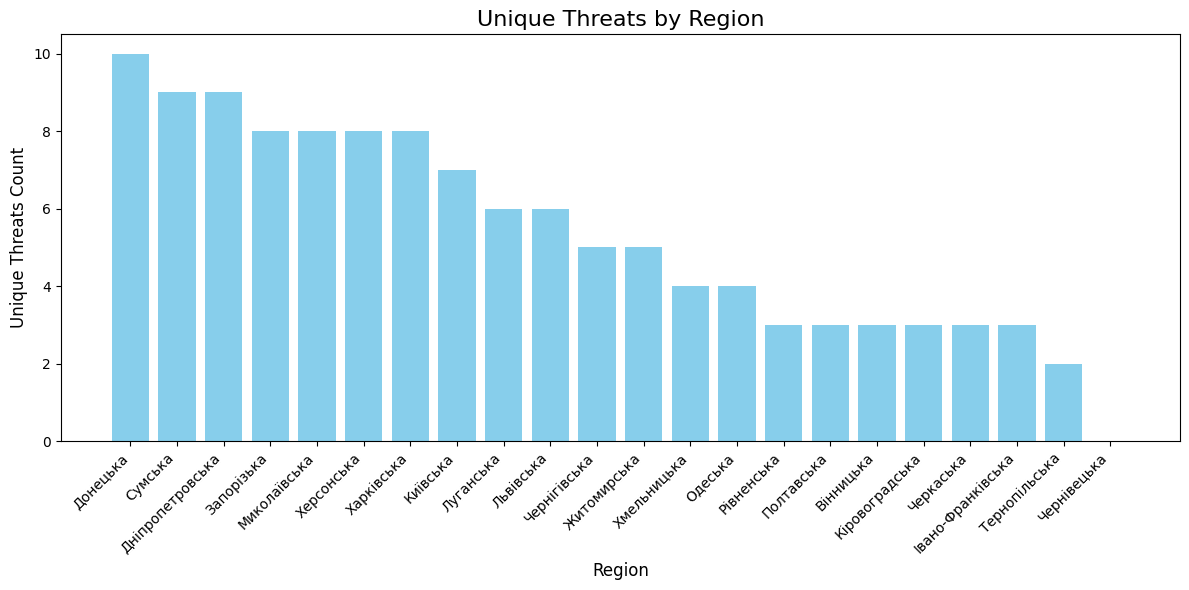

In [22]:
plt.figure(figsize=(12, 6))
plt.bar(region_threat["Region"], region_threat["Unique threats count"], color="skyblue")
plt.title("Unique Threats by Region", fontsize=16)
plt.xlabel("Region", fontsize=12)
plt.ylabel("Unique Threats Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### Cities

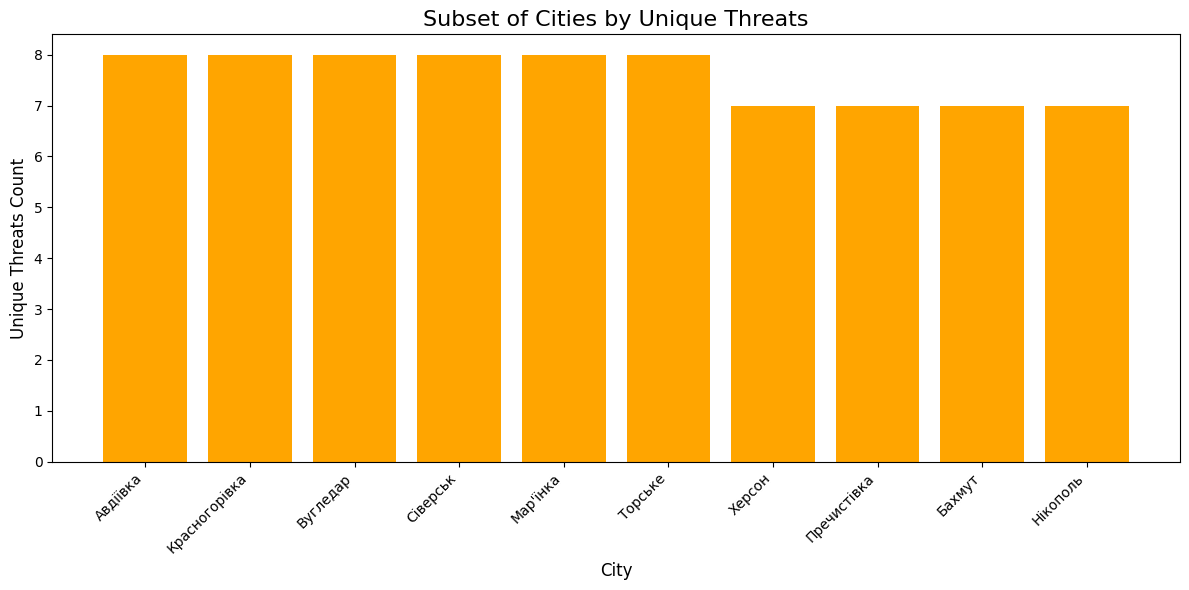

In [23]:
subset_cities = city_threat.iloc[0:10]
plt.figure(figsize=(12, 6))
plt.bar(subset_cities["City"], subset_cities["Unique threats count"], color="orange")
plt.title("Subset of Cities by Unique Threats", fontsize=16)
plt.xlabel("City", fontsize=12)
plt.ylabel("Unique Threats Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

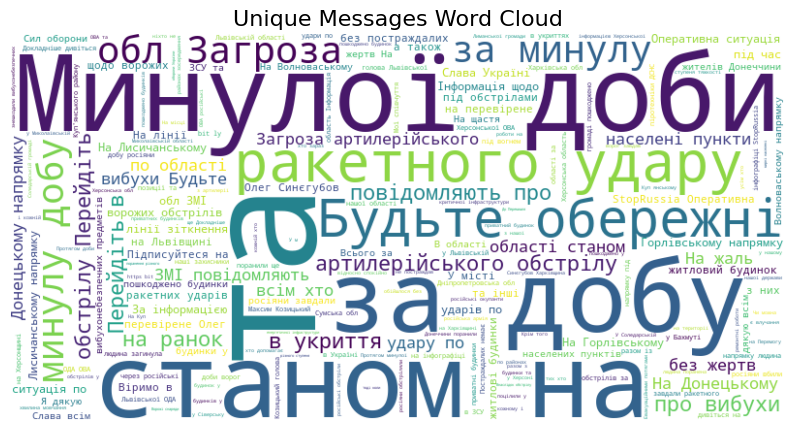

In [24]:


unique_messages = dataset.drop_duplicates(subset=["message_text"])
unique_messages.to_csv("unique.csv")

text_data = " ".join(unique_messages['message_text'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Unique Messages Word Cloud", fontsize=16)
plt.show()


In [26]:
nltk.download("punkt_tab")

morph = pymorphy3.MorphAnalyzer(lang="uk")

messages = dataset["message_text"].dropna().tolist()

def tokineze_and_lemmatize(text):
    tokens = nltk.word_tokenize(text.lower())
    words = [token for token in tokens if token.isalpha()]
    lemmas = [morph.parse(word)[0].normal_form for word in words]
    return lemmas

all_words = []
for message in messages:
    all_words.extend(tokineze_and_lemmatize(message))

word_count = Counter(all_words)
words_count_dataset = pd.DataFrame(word_count.items(), columns=["Words", "Count"])
words_count_dataset = words_count_dataset.sort_values(by="Count", ascending=False)

words_count_dataset.to_csv("words.csv")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/nikitalenyk/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
